# Final Project: 
Dartmouth College, LING48, Spring 2023<br>
Jackline Gathoni Wambui (jackline.w.gathoni.24@dartmouth.edu)                             
Dahlia Igiraneza (dahlia.igiraneza.24@dartmouth.edu)                                                
Paige Nakai (paige.m.nakai.24@dartmouth.edu)


To complete this project, we consulted the following sources:


https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f                                       
https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/                    
https://nlp.stanford.edu/software/CRF-NER.html#Download                      

https://lvngd.com/blog/text-classification-with-python-and-scikit-learn/#classification-model-metrics
https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

Import the necessary libraries

In [147]:
import pandas as pd
import regex as re
import torch
import numpy as np
!pip install transformers
import transformers
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize
from sklearn import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load the dataset

In [148]:
datapath = "/content/CS72 Project_Emails_training_dataset - Sheet1.csv"
df= pd.read_csv(datapath, encoding="'latin1")
df = df.dropna()
df.isnull().values.any()
df = df.sample(frac=1)
df.head()

,Category,Emails
234,Related,Can anyone take my Saturday shift 4-8pm at circ
31,Related,"Hello All,\r\n\r\nSorry for the short notice, ..."
225,Related,does anyone want orozco 7-8 tonight?
4,Related,"Hello All,\r\n\r\nI have a midterm at 7:00 pm ..."
56,Related,Hello all!\r\n\r\nReaching out to see if anyon...


<Axes: xlabel='Category'>

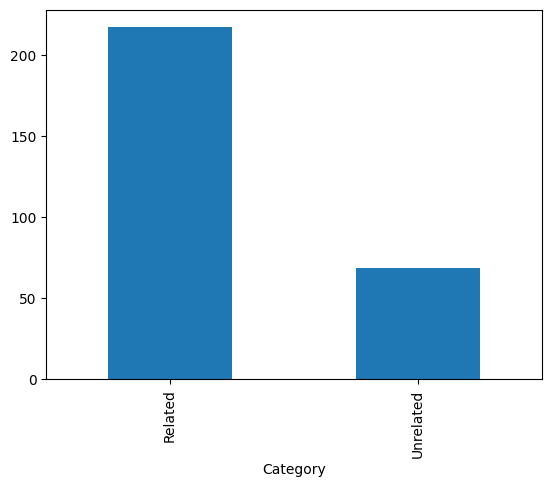

In [149]:
df.groupby(['Category']).size().plot.bar()

In [150]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [151]:
def preprocess_text(sen):
    # Change into a string the input
    # sen = str(sen)
    
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [152]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [153]:
emails = []
sentences = list(df["Emails"])
for sen in sentences:
  emails.append(preprocess_text(sen))

In [154]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Related': 0,
          'Unrelated': 1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Emails']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [155]:

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [156]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))
print(type(df_train))

228 29 29
<class 'pandas.core.frame.DataFrame'>


In [157]:

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 114/114 [20:53<00:00, 10.99s/it]


Epochs: 1 | Train Loss:  0.773                 | Train Accuracy:  0.303                 | Val Loss:  0.661                 | Val Accuracy:  0.552


100%|██████████| 114/114 [20:27<00:00, 10.77s/it]


Epochs: 2 | Train Loss:  0.579                 | Train Accuracy:  0.684                 | Val Loss:  0.485                 | Val Accuracy:  0.828


100%|██████████| 114/114 [20:30<00:00, 10.79s/it]


Epochs: 3 | Train Loss:  0.444                 | Train Accuracy:  0.781                 | Val Loss:  0.342                 | Val Accuracy:  0.862


100%|██████████| 114/114 [20:30<00:00, 10.79s/it]


Epochs: 4 | Train Loss:  0.348                 | Train Accuracy:  0.794                 | Val Loss:  0.225                 | Val Accuracy:  0.966


100%|██████████| 114/114 [20:28<00:00, 10.78s/it]


Epochs: 5 | Train Loss:  0.273                 | Train Accuracy:  0.864                 | Val Loss:  0.184                 | Val Accuracy:  0.897


In [158]:
# # Save the entire model as a `.keras` zip archive.
# model.save('model.keras')

# model1 = tf.keras.models.load_model('model.keras')

# # Show the model architecture
# model1.summary()

In [160]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    y_preds = []
    y_trues = []

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)

              y_trues.append(test_label)

              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              y_preds.append(output.argmax(dim=1))

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
    # confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=["Related", "Unrelated"])
    # print(confusion_matrix)
    
evaluate(model, df_test)

Test Accuracy:  0.724


In [161]:
# y_preds = []
# y_trues = []

# for index,val_text in enumerate(val_texts):
#      tokenized_val_text = tokenizer([val_text], 
#                                     truncation=True,
#                                     padding=True,
#                                     return_tensor='pt')
#      logits = model(tokenized_val_text)
#      prediction = F.softmax(logits, dim=1)
#      y_pred = torch.argmax(prediction).numpy()
#      y_true = val_labels[index]
#      y_preds.append(y_pred)
#      y_trues.append(y_true)

In [162]:
def preprocessing(input_text, tokenizer):
  return tokenizer.encode_plus(input_text, 
                               add_special_tokens = True,
                               max_length = 512,
                               padding='longest',
                               return_attention_mask = True,
                               return_tensors = 'pt'
                               )

In [163]:
def predict(model, userinput):
  input_ids = []
  attention_mask = []
  encoding = preprocessing(userinput, tokenizer)

  input_ids.append(encoding['input_ids'])
  attention_mask.append(encoding['attention_mask'])
  input_ids = torch.cat(input_ids, dim = 0)
  attention_mask = torch.cat(attention_mask, dim = 0)

  output = model(input_ids, attention_mask)
  prediction = 'Related' if np.argmax(output.detach().numpy()).flatten()==0 else 'Unrelated'
  # print("Tensor is: ", output.argmax(dim=1))
  print("This message is: ", prediction)

  return prediction

PART 2: EVENT EXTRACTION

Training the Stanford NLP Tagger Using our own training dataset

In [164]:
import os
import subprocess

jar_path = "/content/stanford-ner.jar"
prop_file = "/content/ner-training.prop"

command = f"java -cp {jar_path} edu.stanford.nlp.ie.crf.CRFClassifier -prop {prop_file}"

result = subprocess.run(command, shell=True, capture_output=True, text=True)

print("Exit code:", result.returncode)
print("Error output:", result.stderr)


Exit code: 0
Error output: Invoked on Mon Jun 05 20:18:30 UTC 2023 with arguments: -prop /content/ner-training.prop
useTypeSeqs2=true
noMidNGrams=true
useWordPairs=true
trainFile=/content/CS72 Project_Emails_training_dataset_StanfordNER - Sheet1.tsv
maxLeft=1
serializeTo=/content/ner-model.ser.gz
wordShape=chris2useLC
useWordTag=true
useDisjunctive=true
useOccurrencePatterns=true
useClassFeature=true
useNGrams=true
useNext=true
usePrev=true
useGazettes=true
useTypeySequences=true
useSymTags=True
usePrevSequences=true
useTypeSeqs=true
useSequences=true
map=word=0,answer=1
useWord=true
useShapeConjunctions=True
numFeatures = 7470
Time to convert docs to feature indices: 0.2 seconds
Current memory used: 4m
numClasses: 6 [0=O,1=0,2=DATE,3=TIME,4=PERSON,5=LOCATION]
numDocuments: 1
numDatums: 430
numFeatures: 7470
Time to convert docs to data/labels: 0.1 seconds
Current memory used: 8m
Running gradient on 2 threads
numWeights: 82890
QNMinimizer called on double function of 82890 variables, u

Tokenize the text and assign labels (i.e DATE, LOCATION, PERSON, etc) to formed tokens.

In [165]:
# -*- coding: utf-8 -*-

def testStanfordNERTTagger(text):
	st = StanfordNERTagger('/content/ner-model.ser.gz',
							'/content/stanford-ner.jar',
							encoding='utf-8')

	tokenized_text = word_tokenize(text)
	classified_text = st.tag(tokenized_text)

	return classified_text
 
 

USING GMAIL API TO ACCESS ONE'S EMAILS

In [166]:
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
#Get credentials from gmail API(jackline.w.gathoni.24@dartmouth.edu)
from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/gmail.modify']


def getService():
    """Shows basic usage of the Gmail API.
    Lists the user's Gmail labels.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('gmail_token.json'):
        creds = Credentials.from_authorized_user_file('gmail_token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('gmail_token.json', 'w') as token:
            token.write(creds.to_json())

    try:
        # Call the Gmail API
        service = build('gmail', 'v1', credentials=creds)
        return service

    except HttpError as error:
        # TODO(developer) - Handle errors from gmail API.
        print(f'An error occurred: {error}')



In [188]:
# Reads incoming emails to check if theyre related to shift-dropping or not and then parse for relevant info(date, time and location).
import base64
service =getService()

def getEmails(service):
    email_details={}
    # to read new messages, get unread specifically,  # add check for no new messages if you decide to do unread messages only
    # results = service.users().messages().list(userId="me", labelIds=["INBOX"], q="from:specific email, is:unread").execute()
    results = service.users().messages().list(maxResults=1, userId='me', labelIds=["INBOX"]).execute()

   
    messages = results.get('messages')  # messages is a list of dictionaries where each dictionary contains a message id.
  
   
    # iterate through all the messages
    for msg in messages:
        # Get the message from its id
        txt = service.users().messages().get(userId='me', id=msg['id']).execute()
  
        # Use try-except to avoid any Errors
        try:
            # Get value of 'payload' from dictionary 'txt'
         
            payload = txt['payload']
            headers = payload['headers']
            parts = payload.get('parts')
         
  
            # Look for Subject, Sender Email and other Recipient emails in the headers
            for d in headers:
                if d['name'] == 'Subject':
                    subject = d['value']
                if d['name'] == 'From':
                    sender = d['value']
                if d['name'] == 'To':
                    recipient = d['value']
                
  
            # from stacksoiverflow to decode the body into plain text
            for part in parts:
                if part["mimeType"] in ["text/plain"]:
                    data = base64.urlsafe_b64decode(part["body"]["data"]).decode("utf-8")
                   

            #add parts of the email to the email dictionary to be used in sending an automated response when available
            email_details["Subject"]=subject
            email_details["Sender"]= sender
            email_details["Message"]= subject +' \n' + data  #adds the subject to the body of the email in case the subject contains relevant information
            email_details["Recipients"]= recipient
            
        except:
            pass
    return email_details
  
  
print("The deets include:" ,getEmails(service))

The deets include: {'Subject': 'Re: Info Extraction and ASR', 'Sender': 'Ryan Dudak <ryan.a.dudak.24@dartmouth.edu>', 'Message': 'Re: Info Extraction and ASR \nHi Jackline,\r\n\r\nYour chatbot does not respond correctly to certain questions related to\r\nordering pizza. For example, when asked "Can I have a pizza with ham and\r\npineapple?" your chatbot responds "Sure! What toppings would you like on\r\nyour pizza?" which is not an intuitive or expected response since the user\r\njust provided the toppings in the previous message. I hope that makes\r\nsense, but please let me know if you have any other questions.\r\n\r\nCheers,\r\nRyan\r\n\r\nOn Mon, Jun 5, 2023 at 4:23 PM Jackline Gathoni <\r\njackline.w.gathoni.24@dartmouth.edu> wrote:\r\n\r\n> Hey Ryan,\r\n>\r\n> I am a bit confused by your feedback. The chatbot seems to be working fine\r\n> on my end, as per the screenshots submitted. Could you clarify what you\r\n> meant by "Ordering pizza interaction is not very smooth"\r\n>\r\n>

In [189]:
# Reads incoming emails to check if theyre related to shift-dropping or not and then parse for relevant info(date, time and location).
import base64
service =getService()

def getEmails(service):
    email_details={}
    # to read new messages, get unread specifically
    # results = service.users().messages().list(userId="me", labelIds=["INBOX"], q="from:specific email, is:unread").execute()
    results = service.users().messages().list(maxResults=1, userId='me', labelIds=["INBOX"]).execute()

    # add check for no new messages if you decide to do unread messages only
    messages = results.get('messages')
  
    # messages is a list of dictionaries where each dictionary contains a message id.
  
    # iterate through all the messages
    for msg in messages:
        # Get the message from its id
        txt = service.users().messages().get(userId='me', id=msg['id']).execute()
  
        # Use try-except to avoid any Errors
        try:
            # Get value of 'payload' from dictionary 'txt'
            payload = txt['payload']
            headers = payload['headers']
            # parts = payload.get('parts')[0] #-> could be some source of error
            parts = payload.get('parts')
  
            # Look for Subject and Sender Email in the headers
            for d in headers:
                if d['name'] == 'Subject':
                    subject = d['value']
                if d['name'] == 'From':
                    sender = d['value']
            
                if d['name'] == 'To':
                    recipient = d['value']
  
            # from stacksoiverflow to decode the body into plain text
            for part in parts:
                if part["mimeType"] in ["text/plain"]:
                    data = base64.urlsafe_b64decode(part["body"]["data"]).decode("utf-8")


            # Printing the subject, sender's email and message
            # print("Subject: ", subject)
            # print('\n')
            # print("From: ", sender)
            # print('\n')
            # print("Message: ", data)
            # print('\n')

            email_details["Subject"]=subject
            email_details["Sender"]= sender
            email_details["Message"]= data
            email_details["Recipients"]= recipient
        
            
        except:
            pass
    return email_details
  
  
print("The deets include:" ,getEmails(service))

The deets include: {'Subject': 'Re: Info Extraction and ASR', 'Sender': 'Ryan Dudak <ryan.a.dudak.24@dartmouth.edu>', 'Message': 'Hi Jackline,\r\n\r\nYour chatbot does not respond correctly to certain questions related to\r\nordering pizza. For example, when asked "Can I have a pizza with ham and\r\npineapple?" your chatbot responds "Sure! What toppings would you like on\r\nyour pizza?" which is not an intuitive or expected response since the user\r\njust provided the toppings in the previous message. I hope that makes\r\nsense, but please let me know if you have any other questions.\r\n\r\nCheers,\r\nRyan\r\n\r\nOn Mon, Jun 5, 2023 at 4:23 PM Jackline Gathoni <\r\njackline.w.gathoni.24@dartmouth.edu> wrote:\r\n\r\n> Hey Ryan,\r\n>\r\n> I am a bit confused by your feedback. The chatbot seems to be working fine\r\n> on my end, as per the screenshots submitted. Could you clarify what you\r\n> meant by "Ordering pizza interaction is not very smooth"\r\n>\r\n> Thank you,\r\n> Jackline\r\n>

Test the BERT Classifier and StanfordNER Model a single email from the gmail account: jackline.w.gathoni.24@dartmouth.edu

In [319]:
# userinput = input("\nPut in a test sentence: \n")

# email_details = getEmails(service)
# userinput = email_details["Message"]
userinput = input("Write in a test message: ")
pred = predict(model, userinput)

if(pred == 'Related'):
  classified_text = testStanfordNERTTagger(userinput)
  print(classified_text)
  

Write in a test message: Can someone take my baker shift from noon ?
This message is:  Related
[('Can', '0'), ('someone', '0'), ('take', '0'), ('my', '0'), ('baker', '0'), ('shift', '0'), ('from', '0'), ('noon', '0'), ('?', '0')]


SCHEDULING: CHECKING ONE'S GOOGLE CALENDAR TO VERIFY IF THEY ARE AVAILABLE FOR THE DROPPED SHIFT TIME

In [351]:
# start_time = datetime.time(hour=2, minute=0, second=0, tzinfo= ZoneInfo('US/Eastern'))
# end_time = datetime.time(hour=3, minute=0, second=0,tzinfo= ZoneInfo('US/Eastern'))

test=[("midnight-2", "TIME")] 
# result = getTime(classified_text)
result = getTime(test)
start_time = None
end_time = None

if result != None:
  start_time = result[0]
  end_time = result[1]
  print("parsed start",start_time)
  print("parsed end",end_time)
  available = checkAvailability(start_time, end_time)

  if available:
    print("Wozzah")
    # test send email
    # send_message(service, destination, emailDetails["Subject"], 
    #             "I can",
    # )

else:
  print("INVALID TIME FORMAT!")



parsed start 00:00:00
parsed end 02:00:00
Getting the upcoming 10 events
Wozzah


In [194]:
pip install pytz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [195]:
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [196]:
from __future__ import print_function

import datetime
import os.path
import pytz

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from zoneinfo import ZoneInfo


# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/calendar.readonly']


def getEvents():
    """Shows basic usage of the Google Calendar API.
    Prints the start and name of the next 10 events on the user's calendar.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('calendar_token.json'):
        creds = Credentials.from_authorized_user_file('calendar_token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                './client_secret_241823786615-5oh4q20ihegr14g6bpst89ke47v65ikf.apps.googleusercontent.com.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('calendar_token.json', 'w') as token:
            token.write(creds.to_json())

    try:
        service = build('calendar', 'v3', credentials=creds)

        # Call the Calendar API
        now = datetime.datetime.utcnow().isoformat() + 'Z'  # 'Z' indicates UTC time
        print('Getting the upcoming 10 events')
        events_result = service.events().list(calendarId='primary', timeMin=now,
                                              maxResults=10, singleEvents=True,
                                              orderBy='startTime').execute()
        events = events_result.get('items', [])

        if not events:
            print('No upcoming events found.')
            return

        # Prints the start and name of the next 10 events
    
    except HttpError as error:
        print('An error occurred: %s' % error)
    return events


def parseDate(rawDate):
    #Transform the datetime given by the API to a python datetime object.
    return datetime.datetime.strptime(rawDate[:-6]+ rawDate[-6:].replace(":",""), '%Y-%m-%dT%H:%M:%S%z')


def checkAvailability(start_time, end_time):
        events = getEvents()

        for event in events:
        # Define the start and end times of your desired interval
        #Example one: non overlapping
            
            # start_time = datetime.time(hour=2, minute=0, second=0, tzinfo= ZoneInfo('US/Eastern'))
            start_date= datetime.datetime.combine(datetime.datetime.today(),start_time )
            # end_time = datetime.time(hour=3, minute=0, second=0,tzinfo= ZoneInfo('US/Eastern'))
            end_date= datetime.datetime.combine(datetime.datetime.today(),end_time )

            eventStart = parseDate(event['start'].get('dateTime', event['start'].get('date'))) 
            eventEnd = parseDate(event['end'].get('dateTime', event['end'].get('date')))
            
                # Check for an overlap between the event and the desired interval
            if eventStart < end_date and eventEnd> start_date:
                print('The desired interval overlaps with event:', event['summary'])
                return False
            
        return True
        # add to calender
         

    

    


# if __name__ == '__main__':
#     main()


Retrieve Time from the Output of the StanfordNER Event Extraction

In [345]:
import datetime
from zoneinfo import ZoneInfo
import re

def getTime(classified_text):
  time = []
  specialTimes={}
  specialTimes["noon"]= "12"
  specialTimes["midnight"]= "00"


  for item in classified_text:
    if(item[1] == 'TIME'):
      
      if not any(chr.isdigit() for chr in item[0]): 
        continue

      #regex for parsing time
      # expression results in five groups
      reTime = r"([0-9]*:*[0-9]*)(.*)(-|to)([0-9]*:*[0-9]*)(.*)"
      timeBreakdown = re.search(reTime, item[0], re.IGNORECASE)


      # Group1 = start_time
      # Group2 = am/pm/ other exceptions like noon, midnight
      # Group3 = -/to
      # Group4 = end_time 
      # Group5 = am/pm/other exceptions like noon, midnight
      if timeBreakdown != None:
        startTime = timeBreakdown.group(1)
        startPeriod = timeBreakdown.group(2)
        to = timeBreakdown.group(3)
        endTime = timeBreakdown.group(4)
        endPeriod =  timeBreakdown.group(5)


        if startPeriod in specialTimes:
          startTime = specialTimes[startPeriod]
        if endPeriod in specialTimes:
          endTime = specialTimes[endPeriod]

        # if endTime == "00":
        #   endTime= "24"


        def splitTime(time, period):
          timeDiv = time.split(':')
          hours= int(timeDiv[0])
         
          if period == 'p' or period =='pm':
            hours+=12
          if len(timeDiv) == 2:
            minutes = int(timeDiv[1])
          else:
            minutes = 0;
          return hours, minutes
     

        start_time = datetime.time(splitTime(startTime, startPeriod)[0], (splitTime(startTime,startPeriod)[1]), tzinfo = ZoneInfo('US/Eastern'))
        end_time = datetime.time(splitTime(endTime, endPeriod)[0], (splitTime(endTime, endPeriod)[1]), tzinfo = ZoneInfo('US/Eastern'))
        return(start_time, end_time)

  return None



In [288]:
import re

# Regular expression for extracting the sender's email from sender's information: .<(.*)>
# reEmail= r".<(.*)>"
# groupEmail = re.search(reEmail, senderInfo, re.IGNORECASE)
# destination = groupEmail
# check that the recipient email is an email other than my specific email

# Add subject to the text incase it has information about shift dropping
reEmail= r".<(.*)>"
emailDetails = getEmails(service)


destination = re.search(reEmail, emailDetails["Sender"], re.IGNORECASE).group(1)
print("destination email is: ", destination)
recipients= re.search(reEmail, emailDetails["Recipients"], re.IGNORECASE)
if recipients:
  recipientEmail = recipients.group(1)
print("other recipient email is: ", recipients)



RefreshError: ignored

In [229]:
#Sends email responding to the sender if available for the specific time window of the shift dropped

from base64 import urlsafe_b64encode
from email.mime.text import MIMEText
service = getService()

#think about adding recipients field for generic emails like work-place emails
#loop through recipeints in case there's more than one
def build_message(destination, obj, body):
    message = MIMEText(body)

    message['to'] = destination
    message['from'] = "jackline.w.gathoni.24@dartmouth.edu"
    message['subject'] = obj
    message['In-Reply-To']= destination
    if recipientEmail != "jackline.w.gathoni.24@dartmouth.edu":
      message['References']= recipients

    # message['References']= recipients

    return {'raw': urlsafe_b64encode(message.as_bytes()).decode()}

def send_message(service, destination, obj, body):
    return service.users().messages().send(
      userId="me",
      body=build_message(destination, obj, body)
    ).execute()


# test send email
send_message(service, destination, emailDetails["Subject"], 
                "I can",
    )

{'id': '1888d5cc5e6dd8f3',
 'threadId': '1888d5cc5e6dd8f3',
 'labelIds': ['SENT']}

In [343]:
# start_time = datetime.time(hour=2, minute=0, second=0, tzinfo= ZoneInfo('US/Eastern'))
# end_time = datetime.time(hour=3, minute=0, second=0,tzinfo= ZoneInfo('US/Eastern'))
# result = getTime(classified_text)
test =["10pm-midnight","TIME"]
result = getTime(test)

print(result)
start_time = None
end_time = None

if result != None:
  start_time = result[0]
  end_time = result[1]
  available = checkAvailability(start_time, end_time)

  if available:
    # test send email
    send_message(service, destination, emailDetails["Subject"], 
                "I can",
    )

else:
  print("INVALID TIME FORMAT!")



None
INVALID TIME FORMAT!


In [179]:
# !python3 "/content/work.ipynb"

In [180]:
# %cd /content/tesss.ipynb
# python3 /content/tesss.ipynb